# Import libraries and packages

In [1]:
# importing the libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
import re
import csv
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
# tokenization and score computation libraries 

!pip install -U nltk
import nltk
import sys
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import nltk.data
import pickle
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import single_meteor_score

     |████████████████████████████████| 1.5 MB 4.4 MB/s eta 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.6.2 which is incompatible.


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Prepare Data for the Model

In [5]:
labels = ['LABEL1', 'LABEL2']
onehot = OneHotEncoder(categories=[labels])
onehot.fit(np.array(labels).reshape(-1, 1))

OneHotEncoder(categories=[['LABEL1', 'LABEL2']])

In [6]:
dataset = pd.read_csv("../input/proj-dataset/en-fr_es_new.csv", index_col=0).reset_index(drop=True)
#train_data, test_data = train_test_split(dataset, test_size=0.2, shuffle=False)
train_data = dataset.copy()
test_data = dataset[-5000:]

In [7]:
# save
train_data.to_csv("train_p2.csv", index=False)
test_data.to_csv("test_p2.csv", index=False)

In [8]:
# load
train_data = pd.read_csv("train_p2.csv", index_col=False)
test_data = pd.read_csv("test_p2.csv", index_col=False)

### Pre-processing

In [9]:
# performing tokenization on the sentences
def lang_tokenizer(label, sentence):
  language = ""
  if label == "ENGLISH":
     language = 'english'
  elif label =='FRENCH':
     language = 'french'
  elif label == 'SPANISH':
     language = 'spanish'
  elif label == 'GREEK':
     language = 'greek'
  regex = re.compile(r'[@_!♫♪#$%^&*(.,)<>?/\|}{~:;-]')
  sentence = regex.sub('',sentence)                  
  sentence = sentence.lower()   
  token_list = word_tokenize(sentence,language=language)                                  #tokenization
  return token_list 

In [10]:
# vocab class for the word to index and index to word mapping

class Vocab:
   def __init__(self):
     self.word2index = {"<unk>":0 , "<sos>":1, "<eos>":2, "<pad>":3}
     self.index2word = {0:"<unk>" , 1:"<sos>", 2:"<eos>", 3:"<pad>"}
     self.vocab_size = len(self.word2index)
     self.word_count = {"<unk>":1 , "<sos>":1, "<eos>":1, "<pad>":1}

   def add_to_vocab(self,token_list):
     for token in token_list:
        if token not in self.word2index:        #add to vocab only if its not already present 
           ind = len(self.word2index)
           self.word2index[token] = ind
           self.index2word[ind] = token
           self.vocab_size += 1
           self.word_count[token] = 1
        else:
           self.word_count[token] += 1  
           
   def tokens2tensor(self,token_list):
      token_indices = list()
      
      #for each token, append its index as per the built vocabulary. If token is not present in the vocab, append the index of <unk> 
      for token in token_list:
          if token in self.word2index:
              token_indices.append(self.word2index[token])
          else:
              token_indices.append(self.word2index["<unk>"])

      #convert the token_indices into tensor              
      sentence_tensor = torch.tensor(token_indices).unsqueeze(1).to(device)
      
      return sentence_tensor

In [11]:
token_columns = {"src_token_indices":[], "label_token_indices":[],"tgt_token_indices":[]}

src_field = Vocab()
tgt_field = Vocab()
for i in range(len(train_data)):
   
   temp_src = train_data['source'].iloc[i]
   temp_tgt = train_data['target'].iloc[i]
   temp_label = train_data['labels'].iloc[i]

   #tokenisation
   src_tokens = lang_tokenizer(temp_label, temp_src)
   tgt_tokens = lang_tokenizer(temp_label, temp_tgt)

   #add to vocab
   src_field.add_to_vocab(src_tokens)
   tgt_field.add_to_vocab(tgt_tokens)

   #convert tokens to indices and add <sos> at the beginning ang <eos> at the end
   src_indices = [src_field.word2index['<sos>']] + [src_field.word2index[token] if token in src_field.word2index else src_field.word2index["<unk>"] for token in src_tokens] + [src_field.word2index['<eos>']]
   tgt_indices = [tgt_field.word2index['<sos>']] + [tgt_field.word2index[token] if token in tgt_field.word2index else tgt_field.word2index["<unk>"] for token in tgt_tokens] + [tgt_field.word2index['<eos>']]
   
   #add to dictionary
   token_columns["src_token_indices"].append(src_indices)
   token_columns["tgt_token_indices"].append(tgt_indices)


train_data["src_token_indices"] =  token_columns["src_token_indices"]
train_data["tgt_token_indices"] =  token_columns["tgt_token_indices"]

#calculate the no of tokens in src
train_data["len_of_src"] = train_data["src_token_indices"].apply(len)
train_data["len_of_tgt"] = train_data["tgt_token_indices"].apply(len)
train_data

,source,target,labels,src_token_indices,tgt_token_indices,len_of_src,len_of_tgt
0,after the introduction of the notes and coins ...,"después de la introducción, el 1 de enero de 2...",SPANISH,"[1, 4, 5, 6, 7, 5, 8, 9, 10, 11, 12, 13, 14, 1...","[1, 4, 5, 6, 7, 8, 9, 5, 10, 5, 11, 5, 12, 13,...",21,23
1,"this reform project needs, however, to be cons...","ahora bien, hay que abordar con prudencia este...",SPANISH,"[1, 21, 22, 23, 24, 25, 26, 19, 27, 28, 29, 2]","[1, 21, 22, 23, 24, 25, 26, 27, 28, 29, 5, 30, 2]",12,13
2,"however, in order for venezuela to be a full m...","cependant, afin que le venezuela soit un membr...",FRENCH,"[1, 25, 30, 31, 32, 33, 26, 19, 34, 35, 36, 37...","[1, 31, 32, 24, 33, 34, 35, 36, 37, 38, 39, 40...",21,21
3,it is high time that these promises were kept.,il est grand temps qu'ils tiennent leurs prome...,FRENCH,"[1, 43, 44, 45, 46, 37, 47, 48, 49, 50, 2]","[1, 49, 50, 51, 52, 53, 54, 55, 56, 57, 41, 58...",11,13
4,i would like to go through one or two detailed...,je voudrais aborder une ou deux questions préc...,FRENCH,"[1, 51, 52, 53, 26, 54, 55, 56, 57, 58, 59, 60...","[1, 59, 60, 61, 62, 63, 64, 65, 66, 67, 5, 68,...",21,19
...,...,...,...,...,...,...,...
59995,the second stage agreement is not perfect.,l'accord de deuxième phase n'est pas parfait.,FRENCH,"[1, 5, 440, 1873, 1295, 44, 127, 3809, 2]","[1, 6575, 5, 549, 1287, 357, 198, 5868, 2]",9,9
59996,here we are contributing to adding value to th...,nous contribuons ici à ajouter de la valeur au...,FRENCH,"[1, 402, 120, 74, 11293, 26, 12998, 3049, 26, ...","[1, 160, 5621, 1982, 38, 3294, 5, 6, 7926, 229...",17,18
59997,the commissioner’s statement suggests this cou...,la déclaration du commissaire montre que cela ...,FRENCH,"[1, 5, 586, 260, 261, 482, 224, 21, 561, 19, 1...","[1, 6, 608, 217, 1217, 211, 24, 413, 1225, 44,...",12,12
59998,they must serve justice and the rule of law.,deben apegarse a la justicia y al estado de de...,SPANISH,"[1, 144, 93, 4774, 2545, 9, 5, 95, 7, 1197, 2]","[1, 1598, 44788, 93, 6, 9308, 13, 501, 4507, 5...",11,12


In [12]:
train_data.to_csv("./traindata.csv")

In [13]:
max_src_len = max(train_data["len_of_src"])
max_tgt_len = max(train_data["len_of_tgt"])
# NUMBER OF BATCHES 
batch_size = 16

In [14]:
def add_padding(token_list,length,field):
    while len(token_list)<length:
       token_list.append(field.word2index["<pad>"])
    return token_list

In [15]:
batch_list = list()

In [16]:
# CLASSES = ['FRENCH','SPANISH'] (  OR ['FRENCH' , 'GREEK'] depending on the dataset)

classes = ['FRENCH', 'SPANISH']
onehot_encoder = OneHotEncoder(categories=[classes])
train_labels = onehot_encoder.fit_transform(np.array(train_data['labels']).reshape(-1, 1)).toarray()

In [17]:
for i in range(0,len(train_data),batch_size):
   batch  =  train_data[i:i+batch_size]
   src_tlen = max(batch["len_of_src"])
   tgt_tlen = max(batch["len_of_tgt"])
   train_data[i:i+batch_size]["src_token_indices"] = train_data[i:i+batch_size]["src_token_indices"].apply(add_padding, args=(src_tlen,src_field)) 
   train_data[i:i+batch_size]["tgt_token_indices"] = train_data[i:i+batch_size]["tgt_token_indices"].apply(add_padding, args=(tgt_tlen,tgt_field)) 

   src = np.vstack(list(train_data[i:i+batch_size]["src_token_indices"]))
   tgt = np.vstack(list(train_data[i:i+batch_size]["tgt_token_indices"]))

   batch_list.append([ src, tgt, train_labels[i:i+batch_size]])
    
random.shuffle(batch_list)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Model

# CONCATENATION OF THE CONDITIONAL LABELS


concatenating the onehot representation of conditional labels with the latent space vectors producedby the encoder stack.

In [ ]:
'''
L - number of layers
N - batch size
H - hidden size
C - conditional label size
'''

In [ ]:
# a : L * N * H
# b : N * C
# return : L * N * (H + C)

def latent_space_concat(a, b):
    return torch.cat((a, b.expand(a.size(0), -1, -1)), dim=-1)

In [ ]:
# example
L, N, H, C = 4, 3, 5, 2

# hidden space
a = torch.arange(L * N * H).reshape(L, N, H)

# conditional labels
b = torch.arange(N * C).reshape(N, C)

# modified hidden space, [L * N * (H + mC)]
c = latent_space_concat(a, b)

[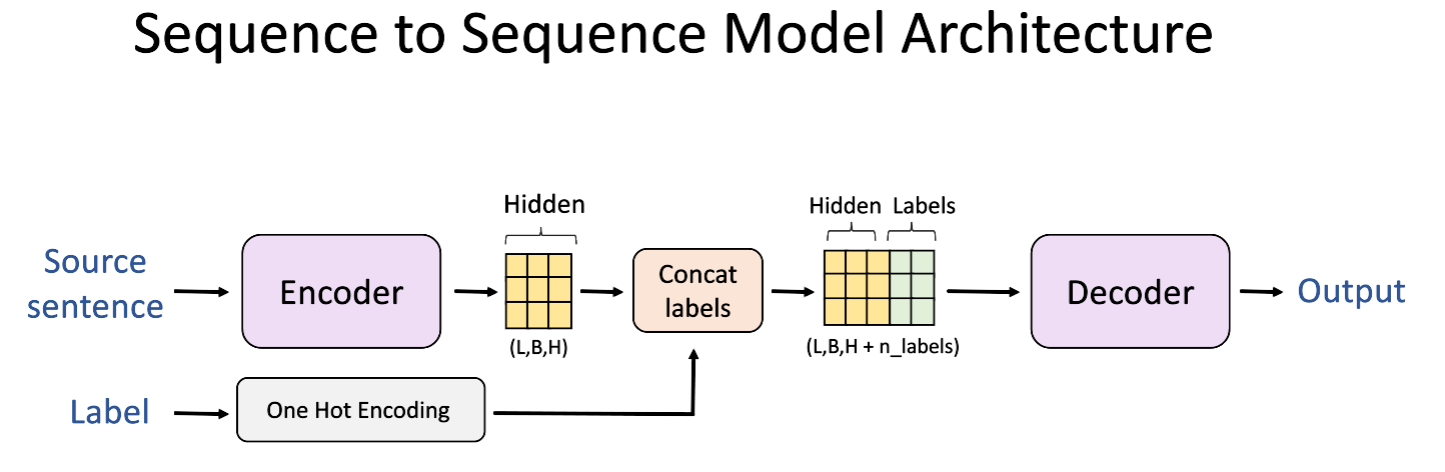](http://)

# Encoder

In [ ]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers, dropout):
        super(EncoderGRU,self).__init__()
        self.hidden_size = hidden_size          
        self.input_size = input_size            #size of hindi vocab, i.e., unique tokens in hindi sentences 
        self.embedding_size = embedding_size    #embedding dimension 
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size,n_layers , dropout=dropout,bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_sentence):
        
        embedding = self.embedding(input_sentence)   
        embedding = self.dropout(embedding) 
        output, hidden= self.gru(embedding)          #gru returns 2 values: output and hidden state 
        '''
         embedding.shape = [sentence_length, batch_size, embedding_size]
         input_sentence.shape = [sentence_length,batch_size]
         output.shape = [sentence_length,batch_size, n_directions * hidden_size)
         hidden.shape = [n_directions*n_layers,batch_size,hidden_size]
        '''
        
        return output,hidden                        


#### Decoder

In [ ]:
class DecoderGRU(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, n_layers,dropout):
        super(DecoderGRU,self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding_size = embedding_size  
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size,n_layers , dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size,output_size)

    def forward(self, input, hidden):
        #input.shape = [batch_size]           
        input = input.unsqueeze(0)                      #added 1 dimension, input.shape = [1,batch_size]  
        embedding = self.embedding(input)               #embedding.shape = [1, batch_size , embedding_size]
        embedding = self.dropout(embedding)     
        output, hidden = self.gru(embedding,hidden)  
        '''
         output.shape = [sentence_length,batch_size, n_directions * hidden_size)
         hidden.shape = [n_directions*n_layers,batch_size,hidden_size]
        '''   
        predicted_output = self.linear(output)         
        predicted_output = predicted_output.squeeze(0)   
        return predicted_output,hidden

#### Seq2Seq

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, input_size, output_size, embedding_size, hidden_size, n_layers, n_labels, dropout, device):
        super().__init__()
        # Encoder class object
        self.encoder = EncoderGRU(input_size, embedding_size, hidden_size, n_layers, dropout).to(device)
        # Decoder class object
        self.decoder = DecoderGRU(output_size, embedding_size, hidden_size+n_labels, output_size, n_layers, dropout).to(device)
        self.device = device
        
    def forward(self, input_sentence, target_output_sentence, labels, teacher_forcing_ratio = 0.5):
        input_sen_len = input_sentence.shape[0]
        batch_size = input_sentence.shape[1]
        output_sen_len = target_output_sentence.shape[0]
        output_vocab_size = self.decoder.output_size
        
        #tensor to store predicted words by the decoder
        predicted_word_indexes = torch.zeros(output_sen_len, batch_size, output_vocab_size).to(self.device)

        #pass the input hindi sentence into the encoder 
        output, hidden = self.encoder(input_sentence)

        # modified hidden space
        hidden = latent_space_concat(hidden, labels)
        
        decoder_input = target_output_sentence[0]  #first input to the decoder is always the init_token, i.e., <sos> token
        
        for i in range(1, output_sen_len):
            #pass the previous word along with the hidden and cell states of encoder into the decoder
            output, hidden = self.decoder(decoder_input, hidden)

            #append the next predicted word
            predicted_word_indexes[i] = output

            use_teacher_forcing = random.random() < teacher_forcing_ratio
            best_word = output.argmax(1)
            if use_teacher_forcing:
              decoder_input = target_output_sentence[i]
            else:
              decoder_input = best_word

        return predicted_word_indexes

# Training phase

HYPER-PARAMETERS

In [ ]:
MAX_LENGTH = 300
input_size = src_field.vocab_size
output_size = tgt_field.vocab_size
#hyperparameters
num_epochs = 20
learning_rate = 0.001
hidden_size = 512
embedding_size = 256           #same for both grus (encoder and decoder)
dropout = 0.5
n_layers = 2
n_labels = 2

In [ ]:
#initialize the object of Seq2Seq class
model = Seq2Seq(input_size, output_size, embedding_size, hidden_size, n_layers, n_labels, dropout, device).to(device)

The parameter initialization has been done as per the paper :  https://arxiv.org/pdf/1409.3215.pdf

In [ ]:
#initialize the parameters
def init_weights(model):
    for name, parameter in model.named_parameters():
        nn.init.uniform_(parameter.data, -0.08, 0.08)
        
model.apply(init_weights)

In [ ]:
def translate_sentence(model, src_sentence, src_field, tgt_field, label, device , max_length=300):
    #tokenize the hindi sentence
    src_tokens = lang_tokenizer("ENGLISH",src_sentence)

    #convert it into tensor
    sentence_tensor = src_field.tokens2tensor(src_tokens)   
    label_arr = torch.as_tensor(onehot_encoder.fit_transform(np.array([label]).reshape(-1, 1)).toarray(),dtype=torch.float32).to(device)
    

    with torch.no_grad():
        #pass the source sentence into the encoder to get the hidden and cell states
        output,hidden = model.encoder(sentence_tensor)
   
    # modified hidden space
    hidden = latent_space_concat(hidden, label_arr)

    predicted_word_indices = [tgt_field.word2index["<sos>"]]              #index of <sos> in english vocab
    predicted_sentence = ""

    #repeat until the len of predicted sentence is less than max_length or the decoder predicts <eos>
    while len(predicted_word_indices)<max_length and predicted_word_indices[-1]!= tgt_field.word2index["<eos>"]:
        prev_word = [predicted_word_indices[-1]]             
        prev_word = torch.tensor(prev_word).to(device)                  #convert into tensor
        best_word = ""
        with torch.no_grad():
            '''
             pass the last predicted word along with the hidden and cell state of the encoder
             into the decoder to get the next predicted word
            '''
            output,hidden = model.decoder(prev_word, hidden)
            _ ,best_word = output.data.topk(1)                          #get the best predicted word index
          
        predicted_word_indices.append(best_word.item())                 #append it to the list of predicted word indices
        predicted_sentence += tgt_field.index2word[best_word.item()]+" "  #append the word corresponding to the predicted index

    translated_sentence = predicted_sentence.replace("<sos>","").replace("<eos>","")
    return translated_sentence


In [ ]:
# Helper function for train() function

def train_batch_list(model, batch_list, criterion, encoder_optimizer, decoder_optimizer):
    for idx,(input_sentence,target_sentence,labels) in enumerate(batch_list):
       
         #get hindi and their corresponding english sentences from the batch
        src = torch.transpose(torch.as_tensor(input_sentence, dtype=torch.int64),0,1).to(device)
        tgt = torch.transpose(torch.as_tensor(target_sentence, dtype=torch.int64),0,1).to(device)
        labels = torch.as_tensor(labels, dtype=torch.float32).to(device)
        

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()    

        #pass the hindi and their corresponding english sentences into the model to get the predicted sentence     
        predicted_sentence = model(src, tgt, labels) 

        #adjust the shapes
        predicted_sentence = predicted_sentence[1:].reshape(-1, predicted_sentence.shape[2])
        tgt = tgt[1:].reshape(-1)

        #calculate loss    
        loss = criterion(predicted_sentence,tgt)
        
        #backpropagate loss
        loss.backward()

        #clip the gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        #opitimize the parameters according to the propagated loss
        encoder_optimizer.step()
        decoder_optimizer.step()
    return loss 

In [ ]:
# reference sentence taken to test on various epochs
ref_sen = "How are you?"

In [ ]:
# train function 

def train(model, batch_list,num_epochs=num_epochs):
    total_loss = 0

    #initialize the optimizer and the criterion(Loss function) to be used
    encoder_optimizer = optim.Adam(model.encoder.parameters(),lr=learning_rate)       #using Adam optimizer for encoder 
    decoder_optimizer = optim.Adam(model.decoder.parameters(),lr=learning_rate)       #using Adam optimizer for decoder
    criterion = nn.CrossEntropyLoss(ignore_index = tgt_field.word2index["<pad>"])       #using CrossEntropyLoss function
    

    for epoch in range(num_epochs):

        model.eval()
        ref_out1 = translate_sentence(model, ref_sen, src_field, tgt_field, "FRENCH", device, max_length=300)
        #print(f"french :: {ref_out}")
        ref_out2 = translate_sentence(model, ref_sen, src_field, tgt_field,"SPANISH",device, max_length=300)
        #print(f"spanish :: {ref_out}")
        model.train()


        #calculate loss for epoch
        loss = train_batch_list(model,batch_list,criterion,encoder_optimizer,decoder_optimizer)
        total_loss += loss.item()

        #save model
        torch.save(model.state_dict(),f"proj_model_{epoch+1}_new.pt")
        
        print(f"f::{ref_out1}\ng :: {ref_out2}")
        print(f'\n\nEpoch: {epoch+1}/{num_epochs}     Loss: {loss.item():.4f}')
        #print(f"french :: {ref_out1}\nspanish :: {ref_out2}")

    print(f"\n\n Total loss ::: {total_loss/len(batch_list):.4f}")


In [ ]:
# function call to the train function
train(model,batch_list, num_epochs=num_epochs)

In [ ]:
#save model
torch.save(model.state_dict(),"proj_model_final_new_data.pt" )